<a href="https://colab.research.google.com/github/rybread1/deep_image/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL

import IPython.display as display
import numpy as np
import time
import functools

In [ ]:
style_path = '/content/FAA_starrry_night.jpg'
content_path = '/content/fresh-flowers-1550252718.jpg'

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


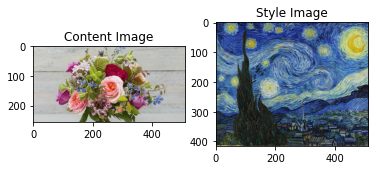

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('vase', 0.2758836),
 ('pot', 0.23367603),
 ('handkerchief', 0.18362409),
 ('picket_fence', 0.04767609),
 ('birdhouse', 0.02609643)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)



input_14
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 415, 512, 64)
  min:  0.0
  max:  696.2169
  mean:  24.927261

block2_conv1
  shape:  (1, 207, 256, 128)
  min:  0.0
  max:  3024.8745
  mean:  151.21072

block3_conv1
  shape:  (1, 103, 128, 256)
  min:  0.0
  max:  6593.093
  mean:  151.57053

block4_conv1
  shape:  (1, 51, 64, 512)
  min:  0.0
  max:  14231.104
  mean:  561.0564

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3638.9065
  mean:  47.22186



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.1430226
    max:  43296.0
    mean:  492.50616

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  121035.836
    mean:  17458.195

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  808611.06
    mean:  18617.133

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  7711674.0
    mean:  231860.02

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  120673.34
    mean:  1723.4766

Contents:
   block5_conv2
    shape:  (1, 16, 32, 512)
    min:  0.0
    max:  1186.9656
    mean:  15.281113


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
style_weight=1
content_weight=100

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers


    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
total_variation_weight=0.01

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))



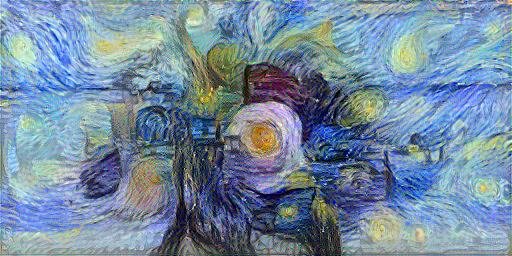

Train step: 2000


In [ ]:
image = tf.Variable(content_image)

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))


In [2]:
!git clone https://github.com/rybread1/deep_image.git

Cloning into 'deep_image'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (356/356), done.
remote: Total 400 (delta 37), reused 373 (delta 28), pack-reused 0
Receiving objects: 100% (400/400), 3.78 MiB | 3.22 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [3]:
from deep_image import style_transfer

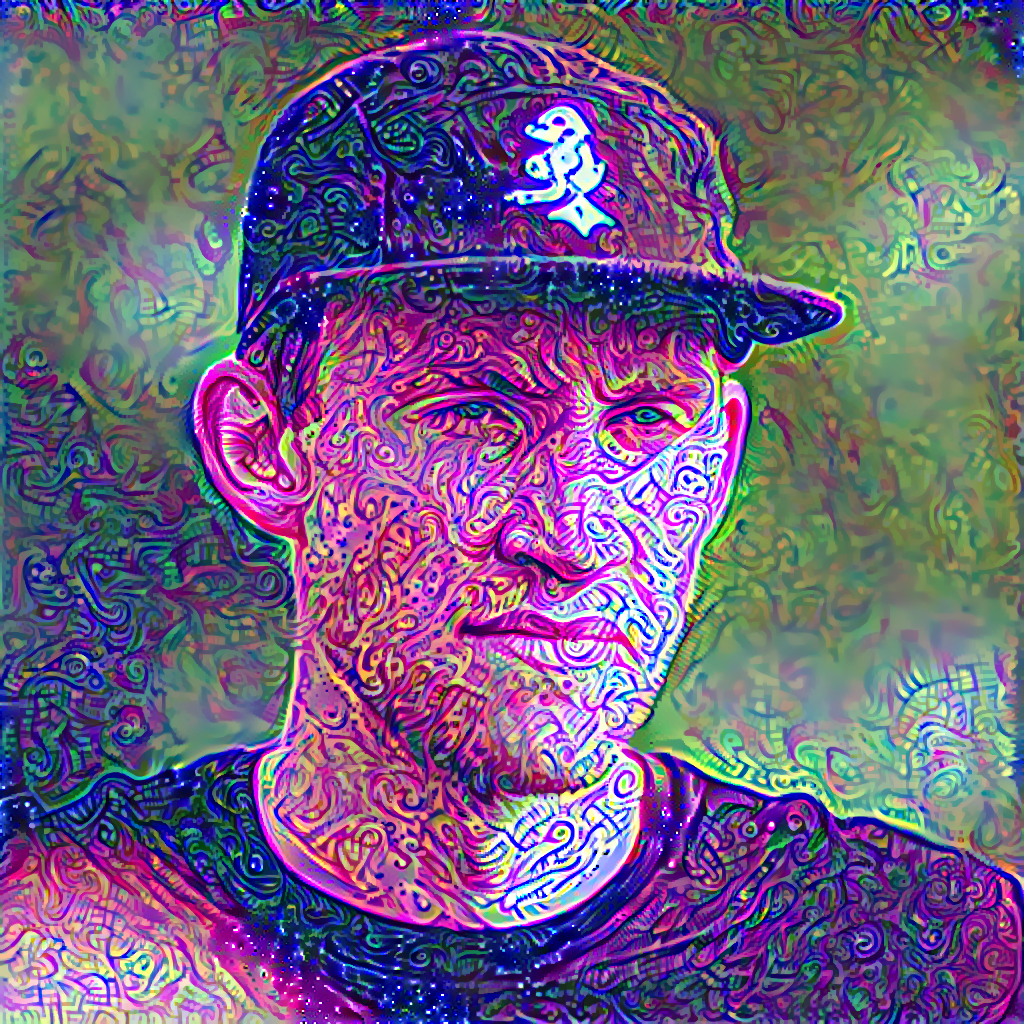

Train step: 1000
Saved as /style_trans.png.jpg


In [24]:
style_transfer.style_transfer(style_path='/content/deep_image/assets/style.jpg', 
                              content_path='/content/1*Quw708WFK3zbFF00TyEOzw.jpeg',
                              style_weight=0.001,
                              content_weight=10,
                              learning_rate=0.01,
                              total_variation_weight=10,
                              epochs=10,
                              steps_per_epoch=100,
                              max_dim=1024)